## Import và tải dữ liệu

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


### Import các thư viện cần thiết

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

In [3]:
annotations_dir = os.path.join(path, 'annotations')
images_dir = os.path.join(path, 'images')
print(annotations_dir)
print(images_dir)

/root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1/annotations
/root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1/images


### Read and split train, val dataset

In [4]:
def filter_images_one_object(images_dir, annotations_dir):
    image_files = []
    for img_file in os.listdir(images_dir):
        img_name = img_file.split('.')[0]
        annotation_file = os.path.join(annotations_dir, img_name+'.xml')
        num_obj = count_num_object(annotation_file)
        if num_obj <= 1:
            image_files.append(img_file)
    return image_files

def count_num_object(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    count = 0
    for obj in root.findall('object'):
        count += 1
    return count

In [5]:
dataset = filter_images_one_object(images_dir, annotations_dir)
print(len(dataset))

3685


In [6]:
train_ds, val_ds = train_test_split(dataset,
                                    test_size=0.2,
                                    random_state=42)

#### Dataset and DataLoader

In [7]:
class ImageDataset(Dataset):
    def __init__(self, dataset, images_dir, annotations_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.image_files = dataset

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        label = None
        height = int(root.find('size/height').text)
        width = int(root.find('size/width').text)
        for obj in root.findall('object'):
            if label is None:
                label = obj.find('name').text

            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            bbox = [
                xmin / width,
                ymin / height,
                xmax / width,
                ymax / height
            ]
        label = 0 if label == 'cat' else 1 if label == 'dog' else -1
        return label, torch.tensor(bbox, dtype=torch.float32)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)

        # annotation file
        annotation_file = img_name.split('.')[0]
        annotation_path = os.path.join(self.annotations_dir, annotation_file+'.xml')

        # get label
        label, bbox = self.parse_annotation(annotation_path)

        # image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label, bbox


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(train_ds,
                             images_dir,
                             annotations_dir,
                             transform)
val_dataset = ImageDataset(val_ds,
                             images_dir,
                             annotations_dir,
                             transform)

train_loader = DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=128,
                        shuffle=False)

#### Model

In [9]:
class TwoHeadModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        num_ftrs = self.base_model.fc.in_features

        # remove original fully connected layer
        self.base_model.fc = nn.Identity()

        # classifier layer
        self.classifier = nn.Linear(num_ftrs, 2)

        # bbox coordinates layer
        self.bbox_coordinates_regressor = nn.Linear(num_ftrs, 4)

    def forward(self, x):
        x = self.base_model(x)
        class_logits = self.classifier(x)
        bbox_coordinates = torch.sigmoid(self.bbox_coordinates_regressor(x))
        return class_logits, bbox_coordinates

In [10]:
model = TwoHeadModel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion_classifier = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Training

In [11]:
def train(model, train_loader, val_loader, criterion_classifier, criterion_bbox, optimizer, epochs=30):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        losses = []
        model.train()
        for images, labels, bboxes in train_loader:
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)

            optimizer.zero_grad()
            class_logits, bbox_coordinates = model(images)

            loss_classifier = criterion_classifier(class_logits, labels)
            loss_bboxes = criterion_bbox(bbox_coordinates, bboxes)
            loss = loss_classifier + loss_bboxes
            losses.append(loss.item())

            loss.backward()
            optimizer.step()
        train_losses.append(sum(losses) / len(losses))

        # validation
        model.eval()
        with torch.no_grad():
            losses_val = []
            correct = 0
            total = 0
            total_loss_bbox = 0
            total_samples = 0
            for images, labels, bboxes in val_loader:
                images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
                class_logits, bbox_coordinates = model(images)

                loss_classifier = criterion_classifier(class_logits, labels)
                loss_bboxes = criterion_bbox(bbox_coordinates, bboxes)
                loss = loss_classifier + loss_bboxes
                losses_val.append(loss.item())

                _, labels_predict = class_logits.max(1)
                correct += (labels_predict == labels).sum()
                total += labels.size(0)

                total_loss_bbox += criterion_bbox(bbox_coordinates, bboxes).item() * images.size(0)
                total_samples += images.size(0)

            val_acc = (correct / total)*100
            val_losses.append(sum(losses_val) / len(losses_val))

            avg_loss_bbox = total_loss_bbox / total_samples

            print(f'Epoch {epoch + 1}/{epochs}\tValidation Acc: {val_acc:.2f}% '
                  f'\tAvg. Bbox Loss: {avg_loss_bbox:.4f}')

    return train_losses, val_losses


In [12]:
train(model, train_loader, val_loader, criterion_classifier, criterion_bbox, optimizer, epochs=10)

Epoch 1/10	Validation Acc: 84.40% 	Avg. Bbox Loss: 0.0269
Epoch 2/10	Validation Acc: 87.92% 	Avg. Bbox Loss: 0.0171
Epoch 3/10	Validation Acc: 96.07% 	Avg. Bbox Loss: 0.0172
Epoch 4/10	Validation Acc: 94.30% 	Avg. Bbox Loss: 0.0163
Epoch 5/10	Validation Acc: 82.23% 	Avg. Bbox Loss: 0.0167
Epoch 6/10	Validation Acc: 94.71% 	Avg. Bbox Loss: 0.0110
Epoch 7/10	Validation Acc: 94.84% 	Avg. Bbox Loss: 0.0102
Epoch 8/10	Validation Acc: 91.04% 	Avg. Bbox Loss: 0.0173
Epoch 9/10	Validation Acc: 95.39% 	Avg. Bbox Loss: 0.0126
Epoch 10/10	Validation Acc: 90.50% 	Avg. Bbox Loss: 0.0140


([0.20504618839671215,
  0.1634090441899995,
  0.09551875821004312,
  0.206534738962849,
  0.14336273927862445,
  0.04801921057514846,
  0.09053712217913319,
  0.20733780755350986,
  0.11553515090296666,
  0.16372014675289392],
 [0.6044031431277593,
  0.3003636598587036,
  0.11107552982866764,
  0.14284796764453253,
  0.40291471282641095,
  0.12643351033329964,
  0.16868366921941438,
  0.42224914332230884,
  0.13397200033068657,
  0.22303023686011633])

#### Predict and show result

In [38]:
def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        class_logit, bbox_coordinate = model(image)
    prob_predict_class, idx = nn.functional.softmax(class_logit, dim=1).max(dim=1)
    label_pred = 'cat' if idx == 0 else 'dog'

    prob = prob_predict_class.item()
    bbox_pred = bbox_coordinate.detach().cpu().numpy()[0]
    return prob, bbox_pred, label_pred

In [36]:
img_file = 'Cats_Test1009.png'
img_path = os.path.join(images_dir, img_file)

annotation_path = os.path.join(annotations_dir, 'Cats_Test1009.xml')

In [32]:
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    label = None
    for obj in root.findall('object'):
        if label is None:
            label = obj.find('name').text

        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

    bbox = [xmin, ymin, xmax, ymax]

    return bbox, label

def process_img(img_path, transform):
    image = Image.open(img_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)
    return image

In [39]:
image = process_img(img_path, transform)
target = parse_annotation(annotation_path)

predict = predict(model, image)
print(predict)

(0.6861451864242554, array([0.3742738 , 0.16719702, 0.7320721 , 0.5888546 ], dtype=float32), 'dog')


0.6861451864242554


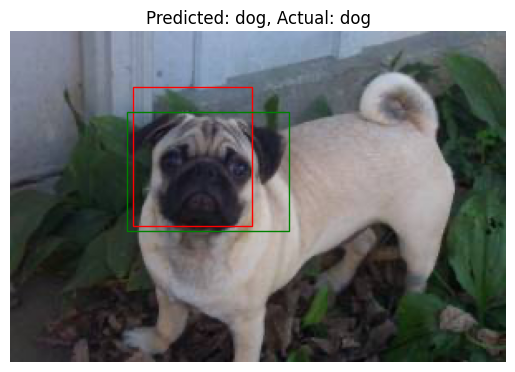

In [40]:
def show_result(img_path, target, predict):
    image = Image.open(img_path).convert('RGB')
    img_height, img_height = image.size

    prob, bbox_pred, label_pred = predict
    bbox, label = target

     # draw result
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = bbox_pred
    xmin_pred = int(xmin_pred * img_height)
    ymin_pred = int(ymin_pred * img_height)
    xmax_pred = int(xmax_pred * img_height)
    ymax_pred = int(ymax_pred * img_height)
    xmin, ymin, xmax, ymax = bbox
    # Create a figure and an axis
    fig, ax = plt.subplots()
    ax.imshow(image)

    # Create a rectangle patch
    rectangle_pred = patches.Rectangle((xmin_pred, ymin_pred), xmax_pred-xmin_pred, ymax_pred-ymin_pred, linewidth=1, edgecolor='r', facecolor='none')
    rectangle = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='green', facecolor='none')

    # Add the rectangle to the plot
    ax.add_patch(rectangle_pred)
    ax.add_patch(rectangle)

    # Display the plot
    print(prob)
    plt.title(f"Predicted: {label_pred}, Actual: {label}")
    plt.axis('off')
    plt.show()

show_result(img_path, target, predict)